## Machine Learning Model Training

**Dataset path:** `../data/raw/StressLevelDataset.csv`

In [20]:
#================================================================
# Add all the libraries imports needed in the project here
#================================================================
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.feature_selection import VarianceThreshold
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Use imblearn Pipeline for pipelines WITH a sampler step
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import os, re, json, joblib

from sklearn.base import clone      # Used when re-fitting best ensembles

from pathlib import Path
import sys
# Point to the project root (adjust parents[1] to parents[2] if your notebook is deeper)
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

#================================================================
# Imports custom preprocessing functions from 'functions.py'
#================================================================

from lib.functions import (is_binary_like,
                        _pretty_p,
                        evaluate_classifier,
                        run_models_with_importances,
                        feature_importances_dataframe
                        )

#================================================================
#  Initialize config
#================================================================
config = None
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")
    
# =============================================================================
# DATA LOADING
# =============================================================================
# df = pd.read_csv(config['input_data']['file1'])     # raw dataset
# df = pd.read_csv(config['output_data']['file1'])    # dataset with no outliers and multicollinearity cols
df = pd.read_csv(config['output_data']['file2'])    # dataset with no multicollinearity cols

**1) Quick checks**

In [21]:
display(df.head())
display(df.shape)
display(df.dtypes)
display(df.isna().sum())

,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,peer_pressure,extracurricular_activities,bullying,stress_level
0,20,0,11,2,1,2,4,2,3,3,2,3,2,3,3,3,2,1
1,8,1,15,5,3,1,4,3,1,2,2,1,4,1,4,5,5,2
2,18,1,14,2,1,2,2,2,2,3,2,2,3,3,3,2,2,1
3,12,1,15,4,3,1,3,4,2,2,2,2,4,1,4,4,5,2
4,28,0,7,2,3,5,1,3,2,4,3,4,3,1,5,0,5,1


(1100, 18)

self_esteem                     int64
mental_health_history           int64
depression                      int64
headache                        int64
blood_pressure                  int64
sleep_quality                   int64
breathing_problem               int64
noise_level                     int64
living_conditions               int64
safety                          int64
basic_needs                     int64
academic_performance            int64
study_load                      int64
teacher_student_relationship    int64
peer_pressure                   int64
extracurricular_activities      int64
bullying                        int64
stress_level                    int64
dtype: object

self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64

**2) Detect numeric, binary-like, and categorical columns**

In [22]:
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
binary_like = [c for c in num_cols_all if is_binary_like(df[c])]
num_cols = [c for c in num_cols_all if c not in binary_like]
print('Numeric (non-binary-like):', num_cols)
print('Binary-like:', binary_like)
print('Categorical:', cat_cols)

Numeric (non-binary-like): ['self_esteem', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'peer_pressure', 'extracurricular_activities', 'bullying', 'stress_level']
Binary-like: ['mental_health_history']
Categorical: []


**3) Train/Test split & preprocessing**

In [23]:
target = 'stress_level'
X = df.drop(columns=[target])
y = df[target]

num_cols_all = X.select_dtypes(include=[np.number]).columns.tolist()
binary_like = [c for c in num_cols_all if is_binary_like(df[c])]
num_cols = [c for c in num_cols_all if c not in binary_like]
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((880, 17), (220, 17))

# KNN (Supervised ML)

**4) Fit KNN and evaluate**

=== KNN (k=5) ===
Prediction Accuracy: 0.8636


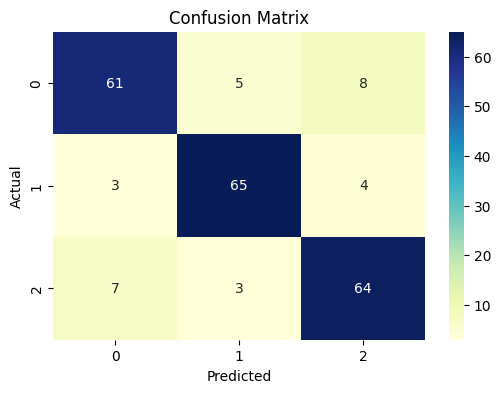


Classification report:
              precision    recall  f1-score   support

           0     0.8592    0.8243    0.8414        74
           1     0.8904    0.9028    0.8966        72
           2     0.8421    0.8649    0.8533        74

    accuracy                         0.8636       220
   macro avg     0.8639    0.8640    0.8638       220
weighted avg     0.8636    0.8636    0.8635       220

k=3: Acc=0.8682
k=5: Acc=0.8682
k=7: Acc=0.8545
k=9: Acc=0.8591
k=11: Acc=0.8455

k=3: CV accuracy=0.8818
k=5: CV accuracy=0.8750
k=7: CV accuracy=0.8750
k=9: CV accuracy=0.8750
k=11: CV accuracy=0.8750


In [24]:
knn = KNeighborsClassifier(n_neighbors=5)
pipe = Pipeline([('prep', preprocess), ('model', knn)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
evaluate_classifier(y_test, y_pred, title='KNN (k=5)')      # accuracy + confusion + per-class precision/recall/F1 

for k in [3,5,7,9,11]:
    m = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=k, weights='distance'))])
    m.fit(X_train, y_train)
    yp = m.predict(X_test)
    print(f'k={k}: Acc={round(accuracy_score(y_test, yp),4)}')
    
print('')

for k in [3,5,7,9,11]:
    m = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=k, weights='distance'))])
    cv = cross_val_score(m, X_train, y_train, cv=5, scoring='accuracy').mean()
    print(f'k={k}: CV accuracy={cv:.4f}')


**5) Simple pre-selection (VarianceThreshold) & Save pipeline**

In [25]:
vt = VarianceThreshold(threshold=0.0)
vt_pipe = Pipeline([('prep', preprocess), ('vt', vt)])
Xt = vt_pipe.fit_transform(X_train)
print('Transformed shape:', Xt.shape)

clf = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=5, weights='distance'))])
clf.fit(X_train, y_train)

Transformed shape: (880, 17)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Supervised ML (Core Models and Metrics)

**6) Train Logistic Regression, KNN, Decision Tree**

=== KNN(k=5) ===
Prediction Accuracy: 0.8682


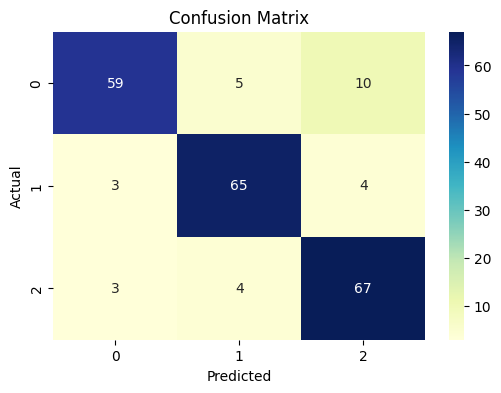


Classification report:
              precision    recall  f1-score   support

           0     0.9077    0.7973    0.8489        74
           1     0.8784    0.9028    0.8904        72
           2     0.8272    0.9054    0.8645        74

    accuracy                         0.8682       220
   macro avg     0.8711    0.8685    0.8679       220
weighted avg     0.8710    0.8682    0.8677       220

KNN(k=5): no native feature_importances_ or coef_ (skipping top-features).

=== LogisticRegression ===
Prediction Accuracy: 0.8864


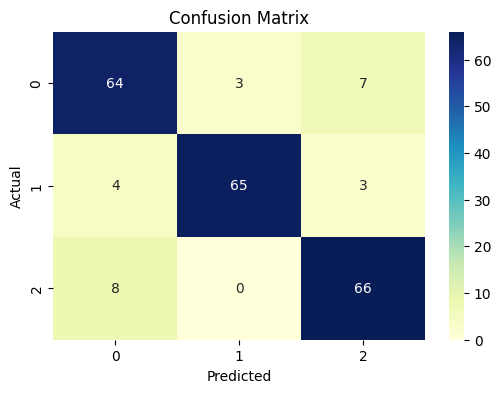


Classification report:
              precision    recall  f1-score   support

           0     0.8421    0.8649    0.8533        74
           1     0.9559    0.9028    0.9286        72
           2     0.8684    0.8919    0.8800        74

    accuracy                         0.8864       220
   macro avg     0.8888    0.8865    0.8873       220
weighted avg     0.8882    0.8864    0.8869       220


Top 10 features for LogisticRegression:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.479485,-1.644160,1.164676,1.096107
12,num__teacher_student_relationship,0.394116,-0.547944,0.153828,0.365296
10,num__academic_performance,0.466775,-0.109706,-0.357069,0.311183
16,remainder__mental_health_history,0.264056,-0.449728,0.185673,0.299819
0,num__self_esteem,0.315391,0.133712,-0.449104,0.299403
9,num__basic_needs,0.418487,-0.234770,-0.183717,0.278991
11,num__study_load,-0.397640,0.239975,0.157664,0.265093
8,num__safety,0.365200,-0.204568,-0.160632,0.243467
2,num__headache,-0.320649,-0.016909,0.337558,0.225039
4,num__sleep_quality,0.232122,0.028675,-0.260797,0.173865


=== DecisionTree ===
Prediction Accuracy: 0.8591


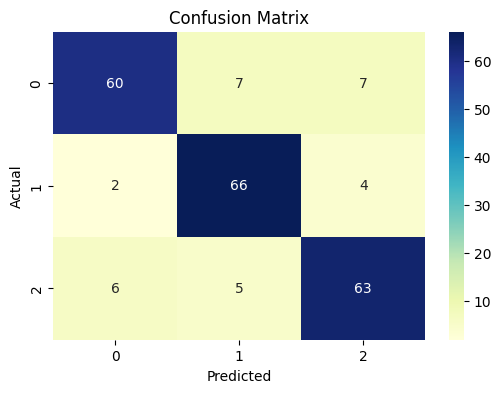


Classification report:
              precision    recall  f1-score   support

           0     0.8824    0.8108    0.8451        74
           1     0.8462    0.9167    0.8800        72
           2     0.8514    0.8514    0.8514        74

    accuracy                         0.8591       220
   macro avg     0.8600    0.8596    0.8588       220
weighted avg     0.8601    0.8591    0.8586       220


Top 10 features for DecisionTree:


,feature,importance
3,num__blood_pressure,0.375749
10,num__academic_performance,0.352574
12,num__teacher_student_relationship,0.049071
4,num__sleep_quality,0.048850
9,num__basic_needs,0.028080
0,num__self_esteem,0.023961
1,num__depression,0.021631
5,num__breathing_problem,0.016667
8,num__safety,0.013696
6,num__noise_level,0.012902


In [26]:
models = {
    'KNN(k=5)': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

results = run_models_with_importances(
    models=models,
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)

**6.1) Uniform comparison table**

In [27]:
rows = []
for name, est in models.items():
    pipe = Pipeline([('prep', preprocess), ('model', est)])
    pipe.fit(X_train, y_train)
    yp = pipe.predict(X_test)
    rows.append({
        'model': name,
        'accuracy': accuracy_score(y_test, yp),
        'balanced_acc': balanced_accuracy_score(y_test, yp),
        'macro_f1': f1_score(y_test, yp, average='macro')
    })
pd.DataFrame(rows).sort_values('macro_f1', ascending=False)

,model,accuracy,balanced_acc,macro_f1
1,LogisticRegression,0.886364,0.886512,0.887302
0,KNN(k=5),0.868182,0.868493,0.867949
2,DecisionTree,0.859091,0.859610,0.858807


# Ensembles (Random Forest, Gradient Boosting and AdaBoost)

**7) Fit and evaluate ensembles**

=== Random Forest ===
Prediction Accuracy: 0.8955


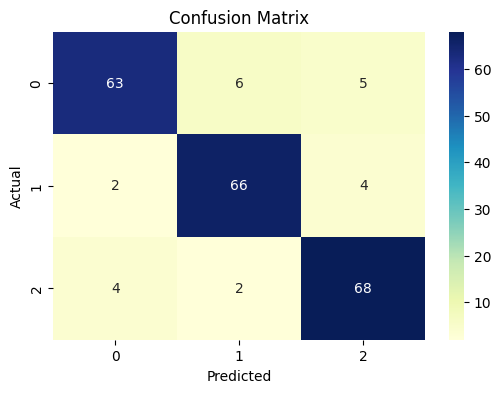


Classification report:
              precision    recall  f1-score   support

           0     0.9130    0.8514    0.8811        74
           1     0.8919    0.9167    0.9041        72
           2     0.8831    0.9189    0.9007        74

    accuracy                         0.8955       220
   macro avg     0.8960    0.8956    0.8953       220
weighted avg     0.8961    0.8955    0.8952       220


Top 10 features for Random Forest:


,feature,importance
3,num__blood_pressure,0.152041
12,num__teacher_student_relationship,0.091152
4,num__sleep_quality,0.088131
1,num__depression,0.087510
10,num__academic_performance,0.084004
13,num__peer_pressure,0.074040
9,num__basic_needs,0.072496
0,num__self_esteem,0.066882
2,num__headache,0.057440
8,num__safety,0.056592


=== Gradient Boosting ===
Prediction Accuracy: 0.8591


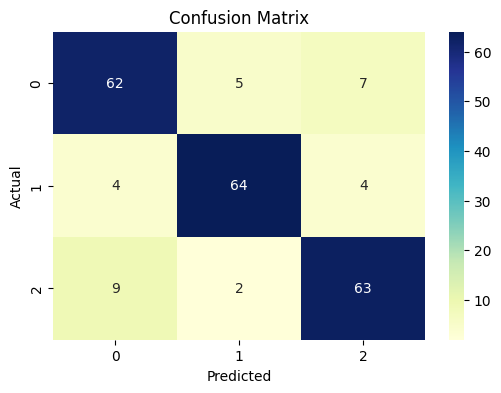


Classification report:
              precision    recall  f1-score   support

           0     0.8267    0.8378    0.8322        74
           1     0.9014    0.8889    0.8951        72
           2     0.8514    0.8514    0.8514        74

    accuracy                         0.8591       220
   macro avg     0.8598    0.8594    0.8596       220
weighted avg     0.8594    0.8591    0.8592       220


Top 10 features for Gradient Boosting:


,feature,importance
3,num__blood_pressure,0.269252
4,num__sleep_quality,0.233815
12,num__teacher_student_relationship,0.142658
10,num__academic_performance,0.138370
9,num__basic_needs,0.034620
0,num__self_esteem,0.033803
14,num__extracurricular_activities,0.028586
1,num__depression,0.020229
8,num__safety,0.017503
11,num__study_load,0.015378


=== AdaBoost ===
Prediction Accuracy: 0.8773


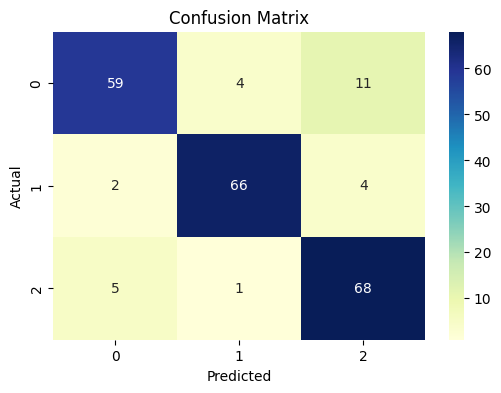


Classification report:
              precision    recall  f1-score   support

           0     0.8939    0.7973    0.8429        74
           1     0.9296    0.9167    0.9231        72
           2     0.8193    0.9189    0.8662        74

    accuracy                         0.8773       220
   macro avg     0.8809    0.8776    0.8774       220
weighted avg     0.8805    0.8773    0.8770       220


Top 10 features for AdaBoost:


,feature,importance
3,num__blood_pressure,0.418225
0,num__self_esteem,0.195036
12,num__teacher_student_relationship,0.051292
4,num__sleep_quality,0.039603
10,num__academic_performance,0.038658
11,num__study_load,0.032877
1,num__depression,0.032452
13,num__peer_pressure,0.029057
9,num__basic_needs,0.028436
14,num__extracurricular_activities,0.027793


In [28]:
# 1) RandomForestClassifier
results_base = run_models_with_importances(
    models={'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)
# 2) GradientBoostingClassifier
results_base = run_models_with_importances(
    models={'Gradient Boosting': GradientBoostingClassifier(random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)
# 3) AdaBoostClassifier
results_base = run_models_with_importances(
    models={'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)

# Hyperparameter Tuning

**8) Tuning RandomForest, GradientBoosting and AdaBoost (GridSearchCV)**

**RandomForestClassifier**

In [29]:
rf_baseline  = Pipeline([('prep', preprocess), ('model', RandomForestClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__max_depth': [10, 50],
    'model__min_samples_split': [4, 16],
    'model__max_leaf_nodes': [250, 1000],
    'model__max_features': ["sqrt", "log2"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = GridSearchCV(rf_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
rf_cv.fit(X_train, y_train)
print('Best params (RF):', rf_cv.best_params_)
best_rf = rf_cv.best_estimator_

best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
print('Test accuracy (best tuned RF):', round(accuracy_score(y_test, pred),4))

Best params (RF): {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 250, 'model__min_samples_split': 16, 'model__n_estimators': 50}
Test accuracy (best tuned RF): 0.8818


**GradientBoostingClassifier**

In [30]:
gb_baseline  = Pipeline([('prep', preprocess), ('model', GradientBoostingClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__learning_rate': [0.05, 1.0],
    'model__max_depth': [10, 50],
    'model__min_samples_split': [4, 16],
    'model__max_leaf_nodes': [250, 1000],
    'model__max_features': ["sqrt", "log2"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gb_cv = GridSearchCV(gb_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gb_cv.fit(X_train, y_train)
print('Best params (Grid):', gb_cv.best_params_)
best_gbc = gb_cv.best_estimator_

best_gbc.fit(X_train, y_train)
pred = best_gbc.predict(X_test)
print('Test accuracy (best tuned GB):', round(accuracy_score(y_test, pred),4))

Best params (Grid): {'model__learning_rate': 1.0, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 250, 'model__min_samples_split': 4, 'model__n_estimators': 50}
Test accuracy (best tuned GB): 0.8955


**AdaBoostClassifier**

In [31]:
ada_baseline  = Pipeline([('prep', preprocess), ('model', AdaBoostClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__learning_rate': [0.05, 1.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ab_cv = GridSearchCV(ada_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
ab_cv.fit(X_train, y_train)
print("AdaBoost best params:", ab_cv.best_params_)
best_ada = ab_cv.best_estimator_

best_ada.fit(X_train, y_train)
pred = best_ada.predict(X_test)
print('Test accuracy (best tuned ADA):', round(accuracy_score(y_test, pred),4))

AdaBoost best params: {'model__learning_rate': 1.0, 'model__n_estimators': 50}
Test accuracy (best tuned ADA): 0.8818


# Imbalanced Data (Multi-class)

**9) Class distribution**

In [32]:
print(y_train.value_counts(normalize=True).round(3))
print(y_test.value_counts(normalize=True).round(3))

stress_level
0    0.340
2    0.335
1    0.325
Name: proportion, dtype: float64
stress_level
0    0.336
2    0.336
1    0.327
Name: proportion, dtype: float64


**10) Baseline Logistic Regression and resampling variants**

=== Baseline LogReg ===
Prediction Accuracy: 0.8864


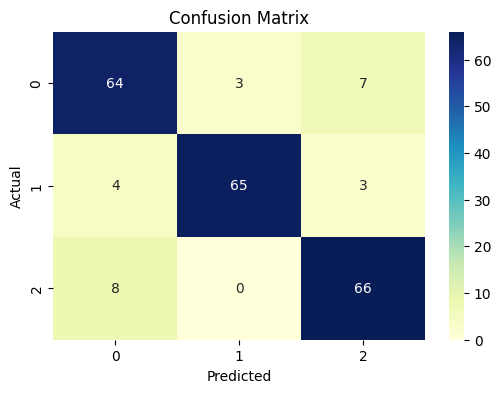


Classification report:
              precision    recall  f1-score   support

           0     0.8421    0.8649    0.8533        74
           1     0.9559    0.9028    0.9286        72
           2     0.8684    0.8919    0.8800        74

    accuracy                         0.8864       220
   macro avg     0.8888    0.8865    0.8873       220
weighted avg     0.8882    0.8864    0.8869       220


Top 10 features for Baseline LogReg:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.479485,-1.644160,1.164676,1.096107
12,num__teacher_student_relationship,0.394116,-0.547944,0.153828,0.365296
10,num__academic_performance,0.466775,-0.109706,-0.357069,0.311183
16,remainder__mental_health_history,0.264056,-0.449728,0.185673,0.299819
0,num__self_esteem,0.315391,0.133712,-0.449104,0.299403
9,num__basic_needs,0.418487,-0.234770,-0.183717,0.278991
11,num__study_load,-0.397640,0.239975,0.157664,0.265093
8,num__safety,0.365200,-0.204568,-0.160632,0.243467
2,num__headache,-0.320649,-0.016909,0.337558,0.225039
4,num__sleep_quality,0.232122,0.028675,-0.260797,0.173865


=== LogReg + ROS ===
Prediction Accuracy: 0.8864


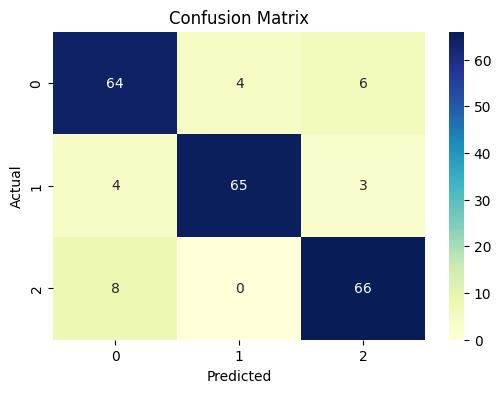


Classification report:
              precision    recall  f1-score   support

           0     0.8421    0.8649    0.8533        74
           1     0.9420    0.9028    0.9220        72
           2     0.8800    0.8919    0.8859        74

    accuracy                         0.8864       220
   macro avg     0.8880    0.8865    0.8871       220
weighted avg     0.8876    0.8864    0.8868       220


Top 10 features for LogReg + ROS:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.476349,-1.653848,1.177498,1.102565
12,num__teacher_student_relationship,0.386694,-0.516080,0.129386,0.344054
16,remainder__mental_health_history,0.293283,-0.508022,0.214738,0.338681
10,num__academic_performance,0.477591,-0.122125,-0.355466,0.318394
0,num__self_esteem,0.311032,0.145959,-0.456991,0.304660
9,num__basic_needs,0.444258,-0.269366,-0.174892,0.296172
11,num__study_load,-0.395145,0.237081,0.158065,0.263430
8,num__safety,0.358557,-0.177155,-0.181402,0.239038
2,num__headache,-0.345724,0.004389,0.341334,0.230482
4,num__sleep_quality,0.238973,0.035398,-0.274371,0.182914


=== LogReg + RUS ===
Prediction Accuracy: 0.8909


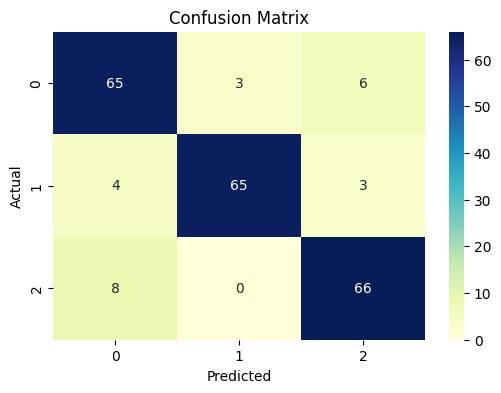


Classification report:
              precision    recall  f1-score   support

           0     0.8442    0.8784    0.8609        74
           1     0.9559    0.9028    0.9286        72
           2     0.8800    0.8919    0.8859        74

    accuracy                         0.8909       220
   macro avg     0.8933    0.8910    0.8918       220
weighted avg     0.8928    0.8909    0.8915       220


Top 10 features for LogReg + RUS:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.442401,-1.627754,1.185352,1.085169
12,num__teacher_student_relationship,0.351281,-0.532426,0.181144,0.354950
10,num__academic_performance,0.497214,-0.129884,-0.367330,0.331476
16,remainder__mental_health_history,0.202973,-0.434556,0.231583,0.289704
0,num__self_esteem,0.290130,0.127619,-0.417749,0.278499
9,num__basic_needs,0.417668,-0.233778,-0.183890,0.278445
11,num__study_load,-0.413136,0.245072,0.168063,0.275424
8,num__safety,0.359280,-0.194235,-0.165045,0.239520
2,num__headache,-0.286479,-0.039420,0.325899,0.217266
4,num__sleep_quality,0.281583,0.015968,-0.297551,0.198368


=== LogReg + SMOTE ===
Prediction Accuracy: 0.8909


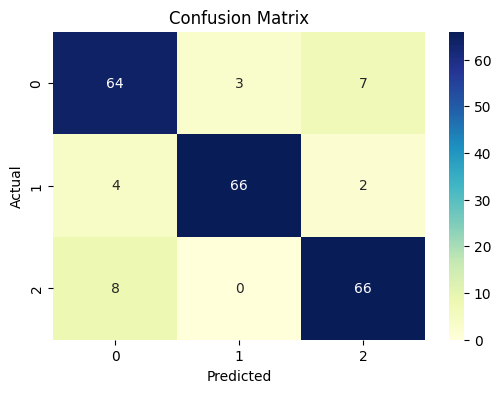


Classification report:
              precision    recall  f1-score   support

           0     0.8421    0.8649    0.8533        74
           1     0.9565    0.9167    0.9362        72
           2     0.8800    0.8919    0.8859        74

    accuracy                         0.8909       220
   macro avg     0.8929    0.8911    0.8918       220
weighted avg     0.8923    0.8909    0.8914       220


Top 10 features for LogReg + SMOTE:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.447498,-1.677361,1.229863,1.118241
12,num__teacher_student_relationship,0.390981,-0.569011,0.178030,0.379341
16,remainder__mental_health_history,0.210175,-0.505527,0.295352,0.337018
0,num__self_esteem,0.338292,0.106876,-0.445167,0.296778
10,num__academic_performance,0.441201,-0.101924,-0.339278,0.294134
9,num__basic_needs,0.384567,-0.235931,-0.148636,0.256378
11,num__study_load,-0.372656,0.242953,0.129702,0.248437
8,num__safety,0.342842,-0.234899,-0.107943,0.228561
2,num__headache,-0.301144,-0.039048,0.340192,0.226795
4,num__sleep_quality,0.229357,0.032576,-0.261933,0.174622


In [33]:
# 1) Baseline (no resampling) -> sklearn Pipeline
results_base = run_models_with_importances(
    models={'Baseline LogReg': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)
# 2) Oversample (ROS) -> imblearn Pipeline + RandomOverSampler
results_ros = run_models_with_importances(
    models={'LogReg + ROS': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=RandomOverSampler(random_state=42),
    top=10,
    plot=False,
    save_csv=False
)
# 3) Undersample (RUS)
results_rus = run_models_with_importances(
    models={'LogReg + RUS': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=RandomUnderSampler(random_state=42),
    top=10,
    plot=False,
    save_csv=False
)
# 4) SMOTE
results_smt = run_models_with_importances(
    models={'LogReg + SMOTE': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=SMOTE(random_state=42),
    top=10,
    plot=False,
    save_csv=False
)

**10.1) Evaluate with macro metrics**

In [34]:
# Baseline (no resampling): sklearn Pipeline is fine here
base = Pipeline([
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Oversampling / Undersampling / SMOTE: MUST use imblearn Pipeline
ros = ImbPipeline([
    ('prep', preprocess),
    ('ros', RandomOverSampler(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

rus = ImbPipeline([
    ('prep', preprocess),
    ('rus', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

smt = ImbPipeline([
    ('prep', preprocess),
    ('smt', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# --- evaluation loop (balanced accuracy + macro F1) ---
for name, pipe in [
    ('Baseline LogReg', base),
    ('LogReg + ROS', ros),
    ('LogReg + RUS', rus),
    ('LogReg + SMOTE', smt)
]:
    pipe.fit(X_train, y_train)          # resampling happens ONLY on train folds
    yp = pipe.predict(X_test)           # test set remains untouched
    print(
        name,
        ' | balanced_acc=', round(balanced_accuracy_score(y_test, yp), 3),
        ' | macro_f1=', round(f1_score(y_test, yp, average="macro"), 3)
    )

Baseline LogReg  | balanced_acc= 0.887  | macro_f1= 0.887
LogReg + ROS  | balanced_acc= 0.887  | macro_f1= 0.887
LogReg + RUS  | balanced_acc= 0.891  | macro_f1= 0.892
LogReg + SMOTE  | balanced_acc= 0.891  | macro_f1= 0.892


## Unsupervised Learning (PCA + Clustering)

**11) PCA (numeric features only)**

In [35]:
num_all = df.select_dtypes(include=[np.number]).columns.tolist()
Xnum = df[num_all].dropna().values
Xnum_scaled = StandardScaler().fit_transform(Xnum)
pca = PCA(n_components=2)
X2 = pca.fit_transform(Xnum_scaled)
print('Explained variance (2 comps):', pca.explained_variance_ratio_.round(3), 'Sum=', round(pca.explained_variance_ratio_.sum(),3))

Explained variance (2 comps): [0.598 0.054] Sum= 0.652


**12) KMeans & Hierarchical clustering on PCA(2)**

In [36]:
km = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_km = km.fit_predict(X2)
agg = AgglomerativeClustering(n_clusters=3)
labels_ag = agg.fit_predict(X2)
print('Silhouette (KMeans):', round(silhouette_score(X2, labels_km), 3))
print('Silhouette (Agglomerative):', round(silhouette_score(X2, labels_ag), 3))

Silhouette (KMeans): 0.742
Silhouette (Agglomerative): 0.737


**2D scatter**

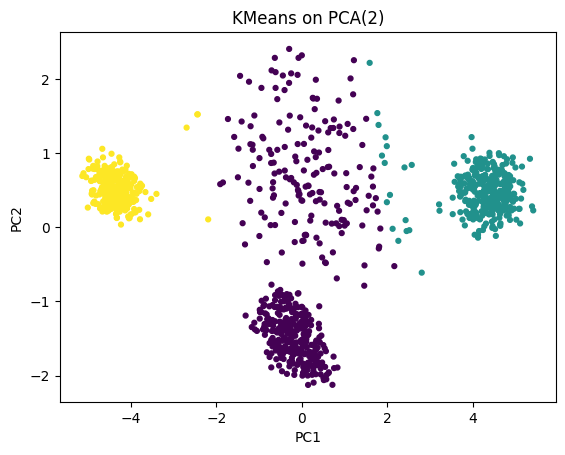

In [37]:
plt.scatter(X2[:,0], X2[:,1], c=labels_km, s=12)
plt.title('KMeans on PCA(2)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

In [38]:
# ===============================
# Streamlit Export Setup (Stress)
# ===============================

# 1) Create export directory
export_dir = Path("../my_streamlit_app/models")
export_dir.mkdir(parents=True, exist_ok=True)

# 2) Collect all *fitted* pipelines from results dicts (from run_models_with_importances)
all_pipelines = {}
for var_name, var_val in list(globals().items()):
    if isinstance(var_val, dict) and "pipelines" in var_val:
        for model_name, pipe in var_val["pipelines"].items():
            all_pipelines[model_name] = pipe

if not all_pipelines:
    raise RuntimeError("No fitted pipelines found. Run the training/evaluation cells before export.")

# 3) (Optional, recommended) Re-fit and export 'best' ensembles with tuned params (using ALL features)
#    - If we used GridSearchCV, we use best_estimator_ (pipeline or estimator).
#    - If we have Optuna/best_params dicts, we build fresh estimators with those params.
#    - Assume we have a 'preprocess' object (e.g., StandardScaler or ColumnTransformer). If not, we fallback.
try:
    _ = preprocess
except NameError:
    from sklearn.preprocessing import StandardScaler
    preprocess = StandardScaler()

if not hasattr(X_train, "columns"):
    raise ValueError("X_train must be a pandas DataFrame with named columns to persist feature_names.")

feature_names = X_train.columns.tolist()  # <-- ALL FEATURES
X_train_all = X_train.copy()
X_test_all  = X_test.copy()

best_pipelines = {}

# Pattern A: GridSearchCV objects
if "rf_cv" in globals() and hasattr(rf_cv, "best_estimator_"):
    rf_best = rf_cv.best_estimator_
    best_pipelines["Random Forest (best)"] = (
        rf_best if isinstance(rf_best, Pipeline)
        else Pipeline([("prep", clone(preprocess)), ("model", clone(rf_best))]).fit(X_train_all, y_train)
    )
if "gb_cv" in globals() and hasattr(gb_cv, "best_estimator_"):
    gb_best = gb_cv.best_estimator_
    best_pipelines["Gradient Boosting (best)"] = (
        gb_best if isinstance(gb_best, Pipeline)
        else Pipeline([("prep", clone(preprocess)), ("model", clone(gb_best))]).fit(X_train_all, y_train)
    )
if "ab_cv" in globals() and hasattr(ab_cv, "best_estimator_"):
    ab_best = ab_cv.best_estimator_
    best_pipelines["AdaBoost (best)"] = (
        ab_best if isinstance(ab_best, Pipeline)
        else Pipeline([("prep", clone(preprocess)), ("model", clone(ab_best))]).fit(X_train_all, y_train)
    )

# Pattern B: Optuna / best_params dicts
if "best_params_rf" in globals() and isinstance(best_params_rf, dict):
    rf_best = RandomForestClassifier(random_state=42, **best_params_rf)
    best_pipelines["Random Forest (best)"] = Pipeline([("prep", clone(preprocess)), ("model", rf_best)]).fit(X_train_all, y_train)
if "best_params_gb" in globals() and isinstance(best_params_gb, dict):
    gb_best = GradientBoostingClassifier(random_state=42, **best_params_gb)
    best_pipelines["Gradient Boosting (best)"] = Pipeline([("prep", clone(preprocess)), ("model", gb_best)]).fit(X_train_all, y_train)
if "best_params_ab" in globals() and isinstance(best_params_ab, dict):
    ab_best = AdaBoostClassifier(random_state=42, **best_params_ab)
    best_pipelines["AdaBoost (best)"] = Pipeline([("prep", clone(preprocess)), ("model", ab_best)]).fit(X_train_all, y_train)

# Merge best pipelines into the export set
all_pipelines.update(best_pipelines)

# 4) (Optional) Add a stable alias to the best model (only if present)
best_model_name = "AdaBoost"
if best_model_name in all_pipelines:
    all_pipelines["BestModel"] = all_pipelines[best_model_name]

# 5) Save each fitted pipeline to .pkl
def safe_name(name: str) -> str:
    return re.sub(r"[^A-Za-z0-9_+-]+", "_", name).strip("_")

for model_name, model_obj in all_pipelines.items():
    model_path = export_dir / f"{safe_name(model_name)}.pkl"
    joblib.dump(model_obj, model_path)
print(f"Saved {len(all_pipelines)} pipelines to: {export_dir}")

# 6) Persist ALL feature names (so Streamlit uses the full schema)
joblib.dump(feature_names, export_dir / "feature_names.pkl")
print("Saved feature_names.pkl (ALL training features)")

# 7) Save test set with ALL features (plus target for evaluation page)
target_col = "stress_level"
test_df = (pd.DataFrame(X_test, columns=feature_names) if not hasattr(X_test, "columns") else X_test.copy())
test_df[target_col] = y_test if getattr(y_test, "name", None) == target_col else pd.Series(y_test).rename(target_col).values
test_df.to_csv(export_dir / "test_set.csv", index=False)
print("Saved test_set.csv")

# 8) Save accuracy metrics per model (using ALL features)
metrics = {}
for model_name, pipe in all_pipelines.items():
    try:
        y_pred = pipe.predict(test_df[feature_names])
        acc = float(accuracy_score(test_df[target_col], y_pred))
        metrics[model_name] = {"accuracy": acc}
    except Exception as e:
        metrics[model_name] = {"error": str(e)}
(export_dir / "metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")
print("Saved metrics.json")

Saved 10 pipelines to: ..\my_streamlit_app\models
Saved feature_names.pkl (ALL training features)
Saved test_set.csv
Saved metrics.json
